# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

2024-04-13 15:05:02.781954: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 15:05:02.786136: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 15:05:02.833894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 15:05:03.797449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
keras.utils.set_random_seed(42)

## Task 1

### a)

In [3]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (
        np.einsum("k,kl,l->", mu2 - mu1, np.linalg.inv(Sigma2), mu2 - mu1)
        + np.einsum("kl,lk->", np.linalg.inv(Sigma2), Sigma1)
        - np.log(np.linalg.det(Sigma1) / np.linalg.det(Sigma2))
        - mu1.shape[0]
    ) / 2

In [4]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    return (
        np.log(np.linalg.det(Sigma2))
        - np.log(np.linalg.det(Sigma1))
        + np.einsum("ik,kl,il->i", x - mu2, np.linalg.inv(Sigma2), x - mu2)
        - np.einsum("ik,kl,il->i", x - mu1, np.linalg.inv(Sigma1), x - mu1)
    ) / 2

### b)

In [5]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)
n = 10000
mu1 = np.array([0.2, 0.2, 0.2, 0, 0])
mu2 = np.array([0, 0, 0.2, 0.2, 0.2])
Sigma1 = np.full((5, 5), 0.1)
np.fill_diagonal(Sigma1, 1)
Sigma2 = np.full((5, 5), -0.2)
np.fill_diagonal(Sigma2, 1)
x = np.concatenate(
    [
        np.random.multivariate_normal(mu1, Sigma1, n),
        np.random.multivariate_normal(mu2, Sigma2, n),
    ]
)
y = np.repeat([1, 0], n)

In [6]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    return np.mean(t[y == 1]) - np.log(np.mean(np.exp(t[y == 0])))

In [7]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042573

In [8]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.3716345568386594

### c)

In [9]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [10]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=5e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [12]:
hist = model.fit(x_train, y_train, epochs=200, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0813 - val_loss: 0.0390
Epoch 2/200


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0330 - val_loss: 0.0063
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -6.9674e-04 - val_loss: -0.0167
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: -0.0246 - val_loss: -0.0330
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0417 - val_loss: -0.0447
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0540 - val_loss: -0.0531
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0630 - val_loss: -0.0592
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0696 - val_loss: -0.0636
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0745 - val_loss: -0.0670
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0783 - val_loss: -0.0695
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0811 - val_loss: -0.0715
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0834 - val_loss: -0.0731
Epoch 13/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

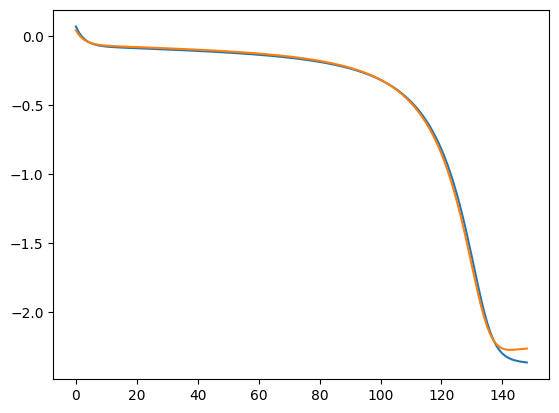

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [14]:
t_x_pred = model.predict(x)[:, 0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


In [15]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

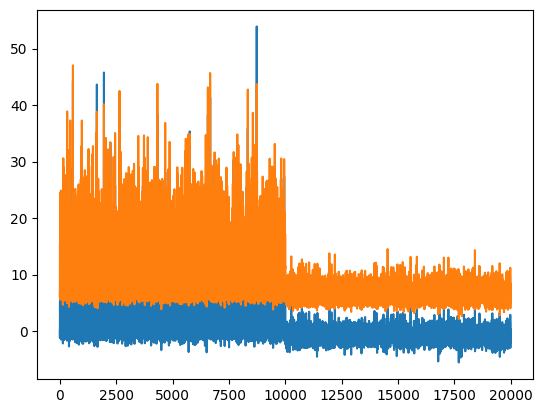

In [16]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

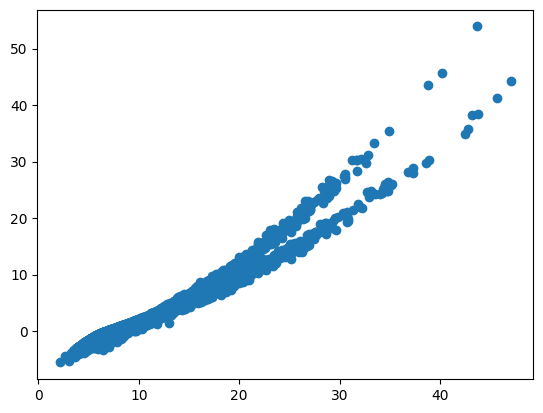

In [17]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [18]:
DV_fun(y, t_x_pred)

2.2835846

In [19]:
DV_fun(y, t_x_opt)

2.3716345568386594

In [20]:
# new data
x_new = np.concatenate(
    [
        np.random.multivariate_normal(mu1, Sigma1, n),
        np.random.multivariate_normal(mu2, Sigma2, n),
    ]
)
y_new = np.repeat([1, 0], n)

In [21]:
t_x_pred = model.predict(x_new)[:, 0]

198/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [22]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [23]:
DV_fun(y_new, t_x_pred)

2.1015038

In [24]:
DV_fun(y_new, t_x_opt)

2.3396448140680217

### f)

In [25]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true)) / n1
    second_term = (
        tf.math.reduce_sum(
            tf.math.multiply(
                tf.math.exp(tf.subtract(T_x, tf.convert_to_tensor(1.0))),
                tf.subtract(tf.convert_to_tensor(1.0), y_true),
            )
        )
        / n2
    )
    return -(first_term - second_term)

In [26]:
def NWJ_fun(y, t):
    return np.mean(t[y == 1]) - np.mean(np.exp(t[y == 0] - 1))

In [27]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=5e-3)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [29]:
hist = model.fit(x_train, y_train, epochs=200, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.3194

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1459 - val_loss: 0.0519
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0345 - val_loss: 0.0259
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0068
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0058 - val_loss: -0.0073
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0184 - val_loss: -0.0180
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0278 - val_loss: -0.0263
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0350 - val_loss: -0.0327
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0407 - val_loss: -0.0377
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0451 - val_loss: -0.0419
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0487 - val_loss: -0.0452
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0517 - val_loss: -0.0481
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

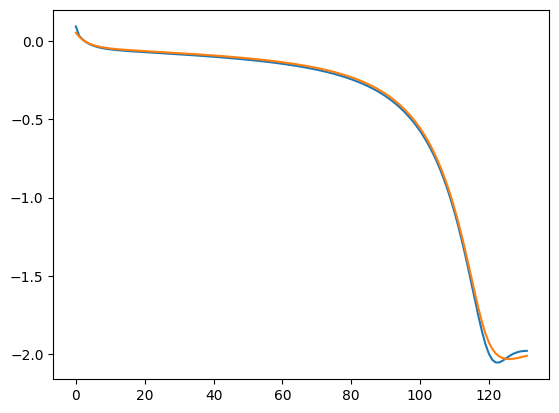

In [30]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [31]:
t_x_pred = model.predict(x)[:, 0]

 50/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step


In [32]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2) + 1

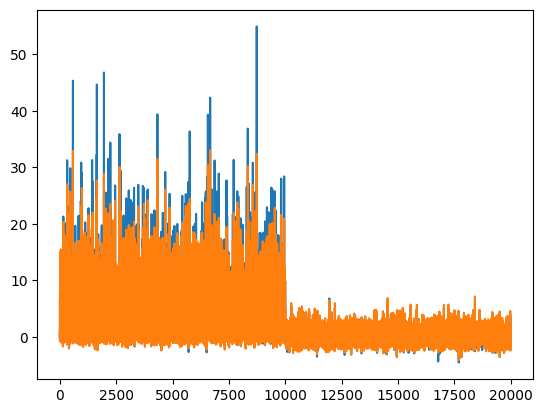

In [33]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

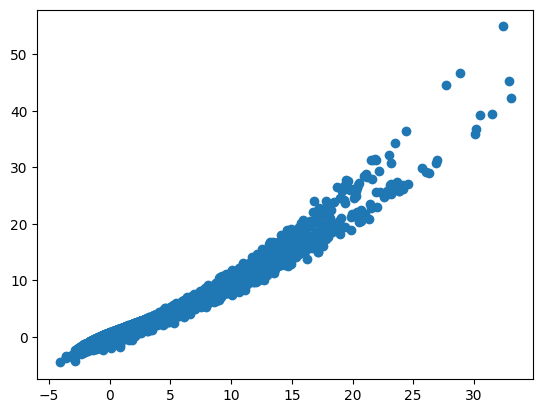

In [34]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [35]:
NWJ_fun(y, t_x_pred)

2.2343621

In [36]:
NWJ_fun(y, t_x_opt)

2.3662098988145295

In [37]:
t_x_pred = model.predict(x_new)[:, 0]

137/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [38]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2) + 1

In [39]:
NWJ_fun(y_new, t_x_pred)

2.0953236

In [40]:
NWJ_fun(y_new, t_x_opt)

2.3211496223229338

It is visible that for both representations (DV and NWJ), KL divergence values estimated using both ratios of densities and neural networks are close to the theoretical value. In case of the NWJ representation, the values predicted by the neural network ($\hat{T}(x)$) are closer to the optimal ones ($T(x)$) - there is no shift.